# Credit Premia Cross-Asset Equity Premia (Optimized Signal)

## Packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
import sys
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CreditEquityPremia\root\src")
from OptimizeSignal import SignalOptimizer

In [3]:
def get_data() -> pd.DataFrame: 
    
    df = SignalOptimizer().optimize_transaction_cost()
    df_prep = (df.assign(
        credit_premia = lambda x: np.where(x.credit_premia == "fa_premia", "Fallen Angel Premia", "High Yield Premia"),
        eq_premia     = lambda x: np.where(x.eq_premia == "IWB", "Russell 1000", "Russell 3000"),
        group_var     = lambda x: x.credit_premia + "\n" + x.eq_premia))
    
    return df_prep

df = get_data()

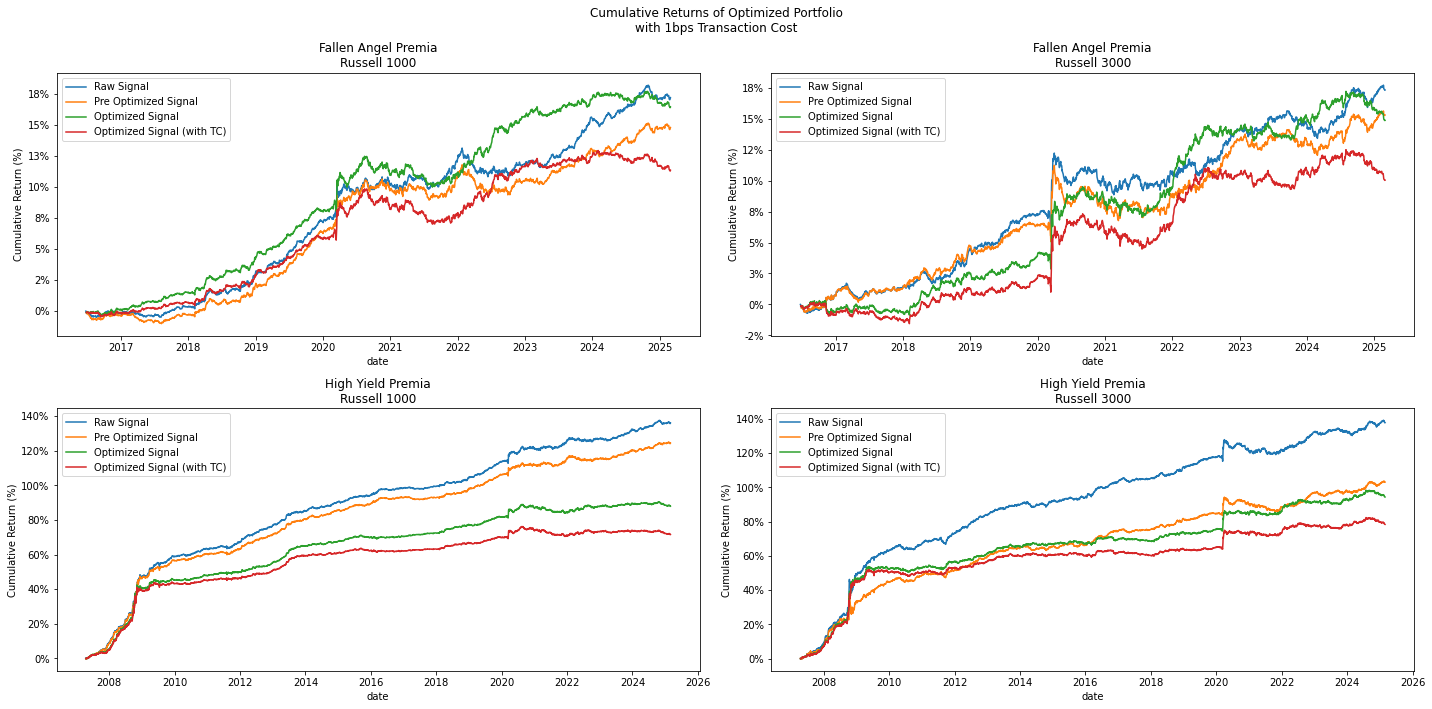

In [5]:
def plot_cumulative_rtn(df: pd.DataFrame) -> plt.Figure:
    
    group_vars = df.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 2, figsize = (20,10))

    renamer = {
        "signal_rtn": "Raw Signal",
        "preopt_rtn": "Pre Optimized Signal",
        "opt_rtn"   : "Optimized Signal",
        "tc_rtn"    : "Optimized Signal (with TC)"}

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df.query(
            "group_var == @group_var").
            set_index("date")
            [["signal_rtn", "preopt_rtn", "opt_rtn", "tc_rtn"]].
            apply(lambda x: np.cumprod(1 + x) - 1).
            rename(columns = renamer).
            plot(
                ax     = ax,
                ylabel = "Cumulative Return (%)",
                title  = group_var))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
        
    fig.suptitle("Cumulative Returns of Optimized Portfolio\nwith 1bps Transaction Cost")
    plt.tight_layout()
    
plot_cumulative_rtn(df)

In [6]:
def get_port(df: pd.DataFrame) -> pd.DataFrame: 

    df_port = (df[
        ["date", "signal_rtn", "preopt_rtn", "opt_rtn", "tc_rtn"]].
        melt(id_vars = "date", var_name = "group").
        groupby(["date", "group"]).
        agg("mean").
        reset_index())
    
    return df_port

df_port = get_port(df)

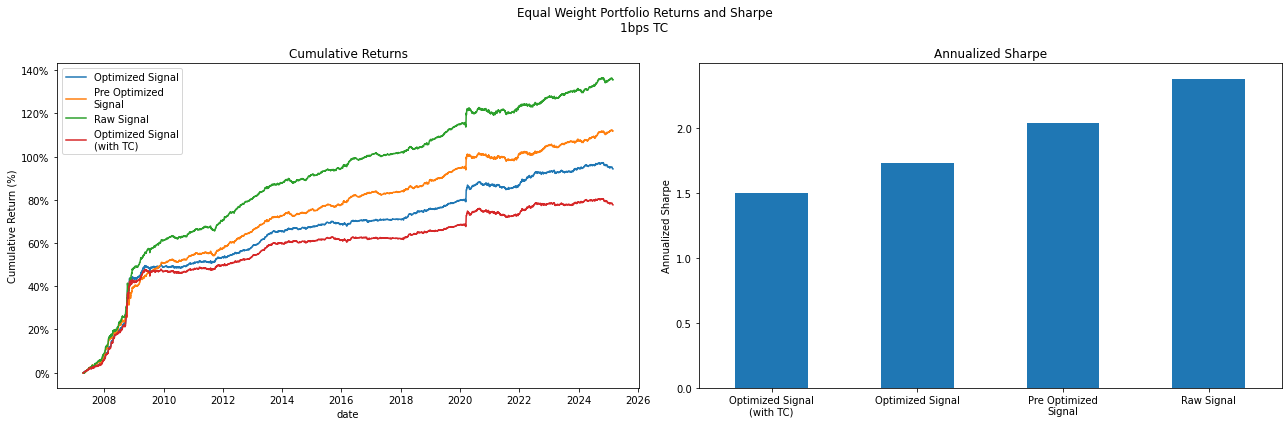

In [7]:
def plot_port_rtn(df: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (18,6))

    renamer = {
        "signal_rtn": "Raw Signal",
        "preopt_rtn": "Pre Optimized\nSignal",
        "opt_rtn"   : "Optimized Signal",
        "tc_rtn"    : "Optimized Signal\n(with TC)"}

    (df_port.rename(
        columns = {"group": ""}).
        pivot(index = "date", columns = "", values = "value").
        rename(columns = renamer).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes[0],
            ylabel = "Cumulative Return (%)",
            title  = "Cumulative Returns"))

    (df_port.drop(
        columns = ["date"]).
        replace(renamer).
        groupby("group").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            kind   = "bar",
            ax     = axes[1],
            rot    = 0,
            xlabel = "",
            legend = False,
            title  = "Annualized Sharpe",
            ylabel = "Annualized Sharpe"))

    fig.suptitle("Equal Weight Portfolio Returns and Sharpe\n1bps TC")
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    plt.tight_layout()
    
plot_port_rtn(df)